In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"otaviohenriq07","key":"2d51f65b3947f31911e7624c35f2e86b"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d prithwirajmitra/covid-face-mask-detection-dataset
!unzip covid-face-mask-detection-dataset.zip
print("Done")

Dataset URL: https://www.kaggle.com/datasets/prithwirajmitra/covid-face-mask-detection-dataset
License(s): copyright-authors
 72% 149M/207M [00:00<00:00, 1.56GB/s]
100% 207M/207M [00:00<00:00, 1.03GB/s]
Archive:  covid-face-mask-detection-dataset.zip
  inflating: New Masks Dataset/Test/Mask/2070.jpg  
  inflating: New Masks Dataset/Test/Mask/2072.jpg  
  inflating: New Masks Dataset/Test/Mask/2083.jpg  
  inflating: New Masks Dataset/Test/Mask/2085.jpg  
  inflating: New Masks Dataset/Test/Mask/2086.jpg  
  inflating: New Masks Dataset/Test/Mask/2110.jpg  
  inflating: New Masks Dataset/Test/Mask/2113.jpg  
  inflating: New Masks Dataset/Test/Mask/2114.jpeg  
  inflating: New Masks Dataset/Test/Mask/2130.jpg  
  inflating: New Masks Dataset/Test/Mask/2132.jpg  
  inflating: New Masks Dataset/Test/Mask/2135.jpg  
  inflating: New Masks Dataset/Test/Mask/2154.png  
  inflating: New Masks Dataset/Test/Mask/2158.png  
  inflating: New Masks Dataset/Test/Mask/2159.png  
  inflating: New Mas

In [3]:
import os
import random
import time
import platform
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics, model_selection
from skimage import io
from PIL import Image
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets, utils
from torchvision.datasets import ImageFolder

In [4]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cuda


In [6]:
data_transforms_train = transforms.Compose([
                                            transforms.RandomResizedCrop(224),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                          ])

data_transforms_test = transforms.Compose([
                                            transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                         ])


In [7]:
data_dir = '/content/New Masks Dataset'
train_dir = os.path.join(data_dir, 'Train')
val_dir = os.path.join(data_dir, 'Validation')
test_dir = os.path.join(data_dir, 'Test')

train_dataset = ImageFolder(train_dir, transform=data_transforms_train)
val_dataset = ImageFolder(val_dir, transform=data_transforms_test)
test_dataset = ImageFolder(test_dir, transform=data_transforms_test)

BATCH_SIZE = 32
NUM_WORKERS = 2

train_dataloader = DataLoader(
                              train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle = True,
                              num_workers=NUM_WORKERS )

val_dataloader = DataLoader(
                            val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle = False,
                            num_workers=NUM_WORKERS
                           )

test_dataloader = DataLoader(
                            test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle = False,
                            num_workers=NUM_WORKERS
                           )

print("DataLoaders criados com sucesso usando ImageFolder.")
print(f"Train batches: {len(train_dataloader)}")
print(f"Validation batches: {len(val_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")

DataLoaders criados com sucesso usando ImageFolder.
Train batches: 19
Validation batches: 10
Test batches: 4


Definição e Ajuste dos Modelos


In [8]:
from torchvision import models
import torch.nn as nn

num_classes = len(train_dataset.classes)

vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6] = nn.Linear(4096, num_classes)
vgg16 = vgg16.to(DEVICE)

alexnet = models.alexnet(pretrained=True)
alexnet.classifier[6] = nn.Linear(4096, num_classes)
alexnet = alexnet.to(DEVICE)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:08<00:00, 68.3MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 194MB/s]


Função de Treino e Validação do Dataset


In [9]:
import torch
from torch import optim
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, model_name="Modelo"):
    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list = [], []

    for epoch in range(num_epochs):
        print(f"\nÉpoca {epoch+1}/{num_epochs}")
        model.train()
        train_loss, train_corrects = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(preds == labels.data)

        epoch_loss = train_loss / len(train_loader.dataset)
        epoch_acc = train_corrects.double() / len(train_loader.dataset)
        train_loss_list.append(epoch_loss)
        train_acc_list.append(epoch_acc.item())


        model.eval()
        val_loss, val_corrects = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc.item())

        print(f"Treino - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
        print(f"Validação - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")


    epochs_list = list(range(num_epochs))
    plt.figure(figsize=(8, 5))
    plt.plot(epochs_list, train_loss_list, label="Train Loss", color='magenta')
    plt.plot(epochs_list, val_loss_list, label="Val Loss", color='green')
    plt.title(f"Loss por Época - {model_name}")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(epochs_list, train_acc_list, label="Train Accuracy", color='magenta')
    plt.plot(epochs_list, val_acc_list, label="Val Accuracy", color='green')
    plt.title(f"Acurácia por Época - {model_name}")
    plt.xlabel("Época")
    plt.ylabel("Acurácia")
    plt.legend()
    plt.show()

    return model



Época 1/50
Treino - Loss: 0.2109, Acc: 0.9100
Validação - Loss: 0.0649, Acc: 0.9771

Época 2/50
Treino - Loss: 0.0771, Acc: 0.9667
Validação - Loss: 0.1381, Acc: 0.9739

Época 3/50
Treino - Loss: 0.0819, Acc: 0.9783
Validação - Loss: 0.0818, Acc: 0.9673

Época 4/50
Treino - Loss: 0.1252, Acc: 0.9550
Validação - Loss: 0.0251, Acc: 0.9935

Época 5/50
Treino - Loss: 0.0840, Acc: 0.9667
Validação - Loss: 0.0493, Acc: 0.9869

Época 6/50
Treino - Loss: 0.0680, Acc: 0.9783
Validação - Loss: 0.0453, Acc: 0.9837

Época 7/50
Treino - Loss: 0.0580, Acc: 0.9833
Validação - Loss: 0.0371, Acc: 0.9935

Época 8/50
Treino - Loss: 0.0624, Acc: 0.9783
Validação - Loss: 0.0407, Acc: 0.9902

Época 9/50
Treino - Loss: 0.0264, Acc: 0.9883
Validação - Loss: 0.0470, Acc: 0.9902

Época 10/50
Treino - Loss: 0.0829, Acc: 0.9750
Validação - Loss: 0.0564, Acc: 0.9837

Época 11/50
Treino - Loss: 0.0849, Acc: 0.9650
Validação - Loss: 0.0453, Acc: 0.9902

Época 12/50
Treino - Loss: 0.0531, Acc: 0.9783
Validação - Los

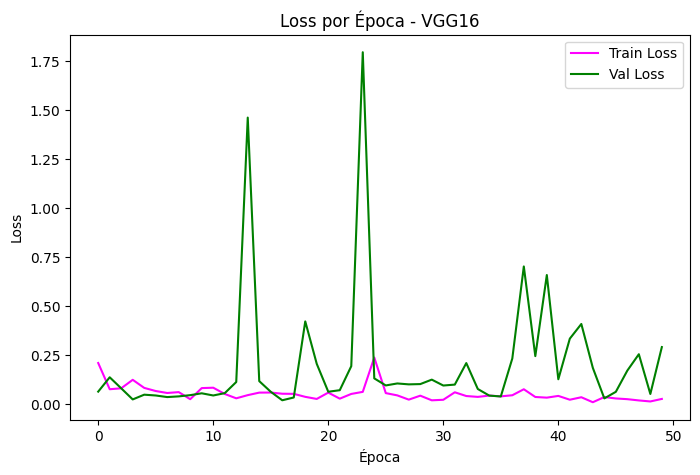

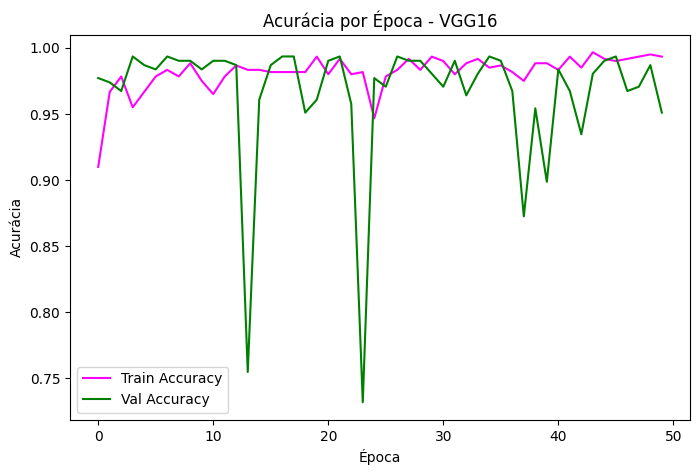


Época 1/50
Treino - Loss: 0.2841, Acc: 0.8800
Validação - Loss: 0.0643, Acc: 0.9804

Época 2/50
Treino - Loss: 0.1096, Acc: 0.9600
Validação - Loss: 0.1584, Acc: 0.9477

Época 3/50
Treino - Loss: 0.0912, Acc: 0.9667
Validação - Loss: 0.1293, Acc: 0.9608

Época 4/50
Treino - Loss: 0.0904, Acc: 0.9650
Validação - Loss: 0.0597, Acc: 0.9706

Época 5/50
Treino - Loss: 0.0700, Acc: 0.9667
Validação - Loss: 0.0824, Acc: 0.9673

Época 6/50
Treino - Loss: 0.0632, Acc: 0.9733
Validação - Loss: 0.0618, Acc: 0.9739

Época 7/50
Treino - Loss: 0.0711, Acc: 0.9733
Validação - Loss: 0.0590, Acc: 0.9804

Época 8/50
Treino - Loss: 0.0775, Acc: 0.9783
Validação - Loss: 0.0581, Acc: 0.9673

Época 9/50
Treino - Loss: 0.0345, Acc: 0.9817
Validação - Loss: 0.0393, Acc: 0.9837

Época 10/50
Treino - Loss: 0.0805, Acc: 0.9733
Validação - Loss: 0.0943, Acc: 0.9608

Época 11/50
Treino - Loss: 0.0820, Acc: 0.9700
Validação - Loss: 0.0953, Acc: 0.9706

Época 12/50
Treino - Loss: 0.0720, Acc: 0.9750
Validação - Los

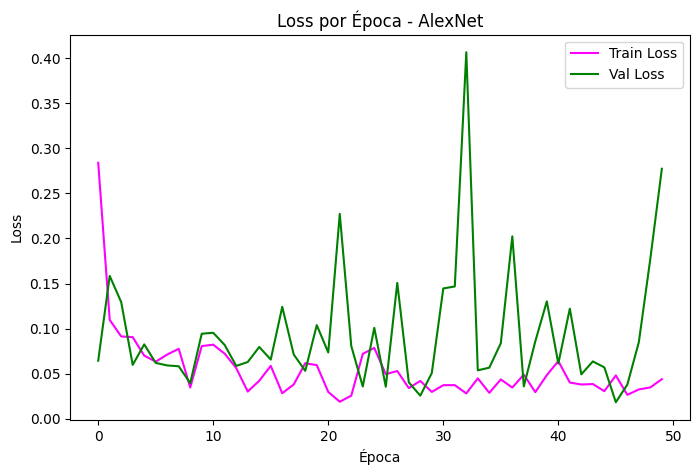

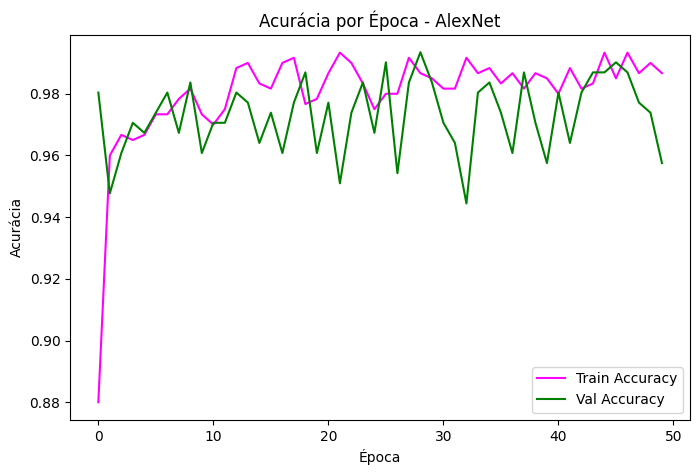

In [10]:
criterion = nn.CrossEntropyLoss()

optimizer_vgg = optim.Adam(vgg16.parameters(), lr=0.0001)
vgg16 = train_model(vgg16, train_dataloader, val_dataloader, criterion, optimizer_vgg,
                    num_epochs=50, model_name="VGG16")

optimizer_alex = optim.Adam(alexnet.parameters(), lr=0.0001)
alexnet = train_model(alexnet, train_dataloader, val_dataloader, criterion, optimizer_alex,
                      num_epochs=50, model_name="AlexNet")


Avaliação com Matriz de Confusão e as Métricas

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, test_loader, model_name):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())


    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=train_dataset.classes,
                yticklabels=train_dataset.classes)
    plt.title(f"Matriz de Confusão - {model_name}")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

    print(f"\n--- {model_name} ---")
    print(classification_report(y_true, y_pred, target_names=train_dataset.classes))


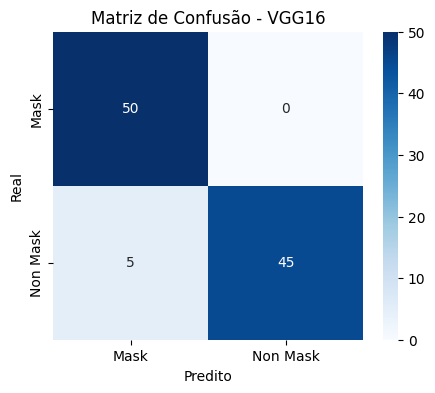


--- VGG16 ---
              precision    recall  f1-score   support

        Mask       0.91      1.00      0.95        50
    Non Mask       1.00      0.90      0.95        50

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



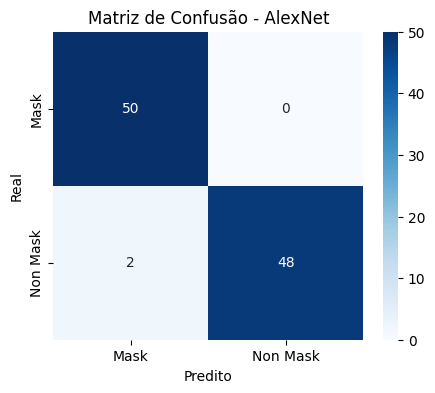


--- AlexNet ---
              precision    recall  f1-score   support

        Mask       0.96      1.00      0.98        50
    Non Mask       1.00      0.96      0.98        50

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



In [12]:
evaluate_model(vgg16, test_dataloader, "VGG16")
evaluate_model(alexnet, test_dataloader, "AlexNet")
